Author: Valentin Malykh, [valentin.malykh@phystech.edu](mailto:valentin.malykh@phystech.edu)

Original Author: [Colin Raffel](http://github.com/craffel)

# Theano Tutorial

Theano is a software package which allows you to write symbolic code and compile it onto different architectures (in particular, CPU and GPU).  It was developed by machine learning researchers at the University of Montreal.  Its use is not limited to machine learning applications, but it was designed with machine learning in mind.  It's especially good for machine learning techniques which are CPU-intensive and benefit from parallelization (e.g. large neural networks).

This tutorial will cover the basic principles of Theano, including some common mental blocks which come up.  It will also cover a simple multi-layer perceptron example.  A more thorough Theano tutorial can be found here: http://deeplearning.net/software/theano/tutorial/

Any comments or suggestions should be directed to [me](http://colinraffel.com/ "Colin Raffel") or feel free to [submit a pull request](https://github.com/craffel/theano-tutorial/pulls "Pull Request").

In [1]:
%matplotlib inline

In [2]:
# Ensure python 3 forward compatibility
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import theano
# By convention, the tensor submodule is loaded as T
import theano.tensor as T

## Basics

### Symbolic variables

In Theano, all algorithms are defined symbolically.  It's more like writing out math than writing code.  The following Theano variables are symbolic; they don't have an explicit value.

In [3]:
# The theano.tensor submodule has various primitive symbolic variable types.
# Here, we're defining a scalar (0-d) variable.
# The argument gives the variable its name.
foo = T.scalar('foo')
# Now, we can define another variable bar which is just foo squared.
bar = foo**2
# It will also be a theano variable.
print(type(bar))
print(bar.type)
# Using theano's pp (pretty print) function, we see that 
# bar is defined symbolically as the square of foo
print(theano.pp(bar))

<class 'theano.tensor.var.TensorVariable'>
TensorType(float64, scalar)
(foo ** TensorConstant{2})


### Functions

To actually compute things with Theano, you define symbolic functions, which can then be called with actual values to retrieve an actual value.

In [4]:
# We can't compute anything with foo and bar yet.
# We need to define a theano function first.
# The first argument of theano.function defines the inputs to the function.
# Note that bar relies on foo, so foo is an input to this function.
# theano.function will compile code for computing values of bar given values of foo
f = theano.function([foo], bar)
print(f(3))

9.0


In [5]:
# Alternatively, in some cases you can use a symbolic variable's eval method.
# This can be more convenient than defining a function.
# The eval method takes a dictionary where the keys are theano variables and the values are values for those variables.
print(bar.eval({foo: 3}))

9.0


In [6]:
# We can also use Python functions to construct Theano variables.
# It seems pedantic here, but can make syntax cleaner for more complicated examples.
def square(x):
    return x**2
bar = square(foo)
print(bar.eval({foo: 3}))

9.0


### theano.tensor

Theano also has variable types for vectors, matrices, and tensors.  The `theano.tensor` submodule has various functions for performing operations on these variables.

In [7]:
A = T.matrix('A')
x = T.vector('x')
b = T.vector('b')
y = T.dot(A, x) + b
# Note that squaring a matrix is element-wise
z = T.sum(A**2)
# theano.function can compute multiple things at a time
# You can also set default parameter values
# We'll cover theano.config.floatX later
b_default = np.array([0, 0], dtype=theano.config.floatX)
linear_mix = theano.function([A, x, theano.Param(b, default=b_default)], [y, z])
# Supplying values for A, x, and b
print(linear_mix(np.array([[1, 2, 3],
                           [4, 5, 6]], dtype=theano.config.floatX), #A
                 np.array([1, 2, 3], dtype=theano.config.floatX), #x
                 np.array([4, 5], dtype=theano.config.floatX))) #b
# Using the default value for b
print(linear_mix(np.array([[1, 2, 3],
                           [4, 5, 6]], dtype=theano.config.floatX), #A
                 np.array([1, 2, 3], dtype=theano.config.floatX))) #x

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
ERROR (theano.gof.opt): Optimization failure due to: LocalOptGroup(use_c_ger,use_c_gemv)
ERROR:theano.gof.opt:Optimization failure due to: LocalOptGroup(use_c_ger,use_c_gemv)
ERROR (theano.gof.opt): node: Gemv{no_inplace}(b, Elemwise{Cast{float64}}.0, A, x, Elemwise{Cast{float64}}.0)
ERROR:theano.gof.opt:node: Gemv{no_inplace}(b, Elemwise{Cast{float64}}.0, A, x, Elemwise{Cast{float64}}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR:theano.gof.opt:TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1309, in transform
    new_repl = opt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/tensor/blas_c

[array([ 18.,  37.]), array(91.0)]
[array([ 14.,  32.]), array(91.0)]


### Shared variables

Shared variables are a little different - they actually do have an explicit value, which can be get/set and is shared across functions which use the variable.  They're also useful because they have state across function calls.

In [8]:
shared_var = theano.shared(np.array([[1, 2], [3, 4]], dtype=theano.config.floatX))
# The type of the shared variable is deduced from its initialization
print(shared_var.type())

<TensorType(float64, matrix)>


In [9]:
# We can set the value of a shared variable using set_value
shared_var.set_value(np.array([[3, 4], [2, 1]], dtype=theano.config.floatX))
# ..and get it using get_value
print(shared_var.get_value())

[[ 3.  4.]
 [ 2.  1.]]


In [10]:
shared_squared = shared_var**2
# The first argument of theano.function (inputs) tells Theano what the arguments to the compiled function should be.
# Note that because shared_var is shared, it already has a value, so it doesn't need to be an input to the function.
# Therefore, Theano implicitly considers shared_var an input to a function using shared_squared and so we don't need
# to include it in the inputs argument of theano.function.
function_1 = theano.function([], shared_squared)
print(function_1())

[[  9.  16.]
 [  4.   1.]]


### updates

The value of a shared variable can be updated in a function by using the updates argument of `theano.function`.

In [11]:
# We can also update the state of a shared var in a function
subtract = T.matrix('subtract')
# updates takes a dict where keys are shared variables and values are the new value the shared variable should take
# Here, updates will set shared_var = shared_var - subtract
function_2 = theano.function([subtract], shared_var, updates={shared_var: shared_var - subtract})
print("shared_var before subtracting [[1, 1], [1, 1]] using function_2:")
print(shared_var.get_value())
# Subtract [[1, 1], [1, 1]] from shared_var
function_2(np.array([[1, 1], [1, 1]], dtype=theano.config.floatX))
print("shared_var after calling function_2:")
print(shared_var.get_value())
# Note that this also changes the output of function_1, because shared_var is shared!
print("New output of function_1() (shared_var**2):")
print(function_1())

shared_var before subtracting [[1, 1], [1, 1]] using function_2:
[[ 3.  4.]
 [ 2.  1.]]
shared_var after calling function_2:
[[ 2.  3.]
 [ 1.  0.]]
New output of function_1() (shared_var**2):
[[ 4.  9.]
 [ 1.  0.]]


### Gradients

A pretty huge benefit of using Theano is its ability to compute gradients.  This allows you to symbolically define a function and quickly compute its (numerical) derivative without actually deriving the derivative.

In [12]:
# Recall that bar = foo**2
# We can compute the gradient of bar with respect to foo like so:
bar_grad = T.grad(bar, foo)
# We expect that bar_grad = 2*foo
bar_grad.eval({foo: 10})

array(20.0)

In [13]:
# Recall that y = Ax + b
# We can also compute a Jacobian like so:
y_J = theano.gradient.jacobian(y, x)
linear_mix_J = theano.function([A, x, b], y_J)
# Because it's a linear mix, we expect the output to always be A
print(linear_mix_J(np.array([[9, 8, 7], [4, 5, 6]], dtype=theano.config.floatX), #A
                   np.array([1, 2, 3], dtype=theano.config.floatX), #x
                   np.array([4, 5], dtype=theano.config.floatX))) #b
# We can also compute the Hessian with theano.gradient.hessian (skipping that here)

ERROR (theano.gof.opt): Optimization failure due to: LocalOptGroup(use_c_ger,use_c_gemv)
ERROR:theano.gof.opt:Optimization failure due to: LocalOptGroup(use_c_ger,use_c_gemv)
ERROR (theano.gof.opt): node: Gemv{no_inplace}(b, Elemwise{Cast{float64}}.0, A, x, Elemwise{Cast{float64}}.0)
ERROR:theano.gof.opt:node: Gemv{no_inplace}(b, Elemwise{Cast{float64}}.0, A, x, Elemwise{Cast{float64}}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR:theano.gof.opt:TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 1309, in transform
    new_repl = opt.transform(node)
  File "//anaconda/lib/python2.7/site-packages/theano/tensor/blas_c.py", line 674, in use_c_gemv
    if not config.blas.ldflags:
  File "//anaconda/lib/python2.7/site-packages/theano/configparser.py", line 320, in __get__


[[ 9.  8.  7.]
 [ 4.  5.  6.]]


### Debugging

Debugging in Theano can be a little tough because the code which is actually being run is pretty far removed from the code you wrote.  One simple way to sanity check your Theano expressions before actually compiling any functions is to use test values.

In [14]:
# Let's create another matrix, "B"
B = T.matrix('B')
# And, a symbolic variable which is just A (from above) dotted against B
# At this point, Theano doesn't know the shape of A or B, so there's no way for it to know whether A dot B is valid.
C = T.dot(A, B)
# Now, let's try to use it
C.eval({A: np.zeros((3, 4), dtype=theano.config.floatX),
        B: np.zeros((5, 6), dtype=theano.config.floatX)})

IndexError: ('The following error happened while compiling the node', Dot22(A, B), '\n', 'list index out of range')

The above error message is a little opaque (and it would be even worse had we not given the Theano variables `A` and `B` names).  Errors like this can be particularly confusing when the Theano expression being computed is very complex.  They also won't ever tell you the line number in your Python code where A dot B was computed, because the actual code being run is not your Python code-it's the compiled Theano code!  Fortunately, "test values" let us get around this issue.  *N.b. - Not all theano methods (for example, and significantly, `scan`) allow for test values*

In [15]:
# This tells Theano we're going to use test values, and to warn when there's an error with them.
# The setting 'warn' means "warn me when I haven't supplied a test value"
theano.config.compute_test_value = 'warn'
# Setting the tag.test_value attribute gives the variable its test value
A.tag.test_value = np.random.random((3, 4)).astype(theano.config.floatX)
B.tag.test_value = np.random.random((5, 6)).astype(theano.config.floatX)
# Now, we get an error when we compute C which points us to the correct line!
C = T.dot(A, B)

ValueError: shapes (3,4) and (5,6) not aligned: 4 (dim 1) != 5 (dim 0)

In [16]:
# We won't be using test values for the rest of the tutorial.
theano.config.compute_test_value = 'off'

Another place where debugging is useful is when an invalid calculation is done, e.g. one which results in `nan`.  By default, Theano will silently allow these `nan` values to be computed and used, but this silence can be catastrophic to the rest of your Theano computation.  At the cost of speed, we can instead have Theano compile functions in `DebugMode`, where an invalid computation causes an error

In [17]:
# A simple division function
num = T.scalar('num')
den = T.scalar('den')
divide = theano.function([num, den], num/den)
print(divide(10, 2))
# This will cause a NaN
print(divide(0, 0))

5.0
nan


In [18]:
# To compile a function in debug mode, just set mode='DebugMode'
divide = theano.function([num, den], num/den, mode='DebugMode')
# NaNs now cause errors
print(divide(0, 0))

InvalidValueError: InvalidValueError
        type(variable) = TensorType(float64, scalar)
        variable       = Elemwise{true_div,no_inplace}.0
        type(value)    = <type 'numpy.ndarray'>
        dtype(value)   = float64
        shape(value)   = ()
        value          = nan
        min(value)     = nan
        max(value)     = nan
        isfinite       = False
        client_node    = None
        hint           = perform output
        specific_hint  = non-finite elements not allowed
        context        = ...
  Elemwise{true_div,no_inplace} [id A] ''   
   |num [id B]
   |den [id C]

        

### Using the CPU vs GPU

Theano can transparently compile onto different hardware.  What device it uses by default depends on your `.theanorc` file and any environment variables defined, as described in detail here: http://deeplearning.net/software/theano/library/config.html
Currently, you should use float32 when using most GPUs, but most people prefer to use float64 on a CPU.  For convenience, Theano provides the floatX configuration variable which designates what float accuracy to use.  For example, you can run a Python script with certain environment variables set to use the CPU:

`THEANO_FLAGS=device=cpu,floatX=float64 python your_script.py`

or GPU:

`THEANO_FLAGS=device=gpu,floatX=float32 python your_script.py`

In [19]:
# You can get the values being used to configure Theano like so:
print(theano.config.device)
print(theano.config.floatX)

cpu
float64


In [20]:
# You can also get/set them at runtime:
old_floatX = theano.config.floatX
theano.config.floatX = 'float32'

In [21]:
# Be careful that you're actually using floatX!
# For example, the following will cause var to be a float64 regardless of floatX due to numpy defaults:
var = theano.shared(np.array([1.3, 2.4]))
print(var.type()) #!!!
# So, whenever you use a numpy array, make sure to set its dtype to theano.config.floatX
var = theano.shared(np.array([1.3, 2.4], dtype=theano.config.floatX))
print(var.type())
# Revert to old value
theano.config.floatX = old_floatX

<TensorType(float64, vector)>
<TensorType(float32, vector)>


## Example: MLP

Defining a multilayer perceptron is out of the scope of this tutorial; please see here for background information:
http://en.wikipedia.org/wiki/Multilayer_perceptron.  We will be using the convention that datapoints are column vectors.

### Layer class

We'll be defining our multilayer perceptron as a series of "layers", each applied successively to the input to produce the network output.  Each layer is defined as a class, which stores a weight matrix and a bias vector and includes a function for computing the layer's output.  

Note that if we weren't using Theano, we might expect the `output` method to take in a vector and return the layer's activation in response to this input.  However, with Theano, the `output` function is instead meant to be used to _create_ (using `theano.function`) a function which can take in a vector and return the layer's activation.  So, if you were to pass, say, a `np.ndarray` to the `Layer` class's `output` function, you'd get an error.  Instead, we'll construct a function for actually computing the `Layer`'s activation outside of the class itself.

In [22]:
class Layer(object):
    def __init__(self, W_init, b_init, activation):
        '''
        A layer of a neural network, computes s(Wx + b) where s is a nonlinearity and x is the input vector.

        :parameters:
            - W_init : np.ndarray, shape=(n_output, n_input)
                Values to initialize the weight matrix to.
            - b_init : np.ndarray, shape=(n_output,)
                Values to initialize the bias vector
            - activation : theano.tensor.elemwise.Elemwise
                Activation function for layer output
        '''
        # Retrieve the input and output dimensionality based on W's initialization
        n_output, n_input = W_init.shape
        # Make sure b is n_output in size
        assert b_init.shape == (n_output,)
        # All parameters should be shared variables.
        # They're used in this class to compute the layer output,
        # but are updated elsewhere when optimizing the network parameters.
        # Note that we are explicitly requiring that W_init has the theano.config.floatX dtype
        self.W = theano.shared(value=W_init.astype(theano.config.floatX),
                               # The name parameter is solely for printing purporses
                               name='W',
                               # Setting borrow=True allows Theano to use user memory for this object.
                               # It can make code slightly faster by avoiding a deep copy on construction.
                               # For more details, see
                               # http://deeplearning.net/software/theano/tutorial/aliasing.html
                               borrow=True)
        # We can force our bias vector b to be a column vector using numpy's reshape method.
        # When b is a column vector, we can pass a matrix-shaped input to the layer
        # and get a matrix-shaped output, thanks to broadcasting (described below)
        self.b = theano.shared(value=b_init.reshape(n_output, 1).astype(theano.config.floatX),
                               name='b',
                               borrow=True,
                               # Theano allows for broadcasting, similar to numpy.
                               # However, you need to explicitly denote which axes can be broadcasted.
                               # By setting broadcastable=(False, True), we are denoting that b
                               # can be broadcast (copied) along its second dimension in order to be
                               # added to another variable.  For more information, see
                               # http://deeplearning.net/software/theano/library/tensor/basic.html
                               broadcastable=(False, True))
        self.activation = activation
        # We'll compute the gradient of the cost of the network with respect to the parameters in this list.
        self.params = [self.W, self.b]
        
    def output(self, x):
        '''
        Compute this layer's output given an input
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for layer input

        :returns:
            - output : theano.tensor.var.TensorVariable
                Mixed, biased, and activated x
        '''
        # Compute linear mix
        lin_output = T.dot(self.W, x) + self.b
        # Output is just linear mix if no activation function
        # Otherwise, apply the activation function
        return (lin_output if self.activation is None else self.activation(lin_output))

### MLP class

Most of the functionality of our MLP is contained in the `Layer` class; the `MLP` class is essentially just a container for a list of `Layer`s and their parameters.  The `output` function simply recursively computes the output for each layer.  Finally, the `squared_error` returns the squared Euclidean distance between the output of the network given an input and the desired (ground truth) output.  This function is meant to be used as a cost in the setting of minimizing cost over some training data.  As above, the `output` and `squared error` functions are not to be used for actually computing values; instead, they're to be used to create functions which are used to compute values.

In [23]:
class MLP(object):
    def __init__(self, W_init, b_init, activations):
        '''
        Multi-layer perceptron class, computes the composition of a sequence of Layers

        :parameters:
            - W_init : list of np.ndarray, len=N
                Values to initialize the weight matrix in each layer to.
                The layer sizes will be inferred from the shape of each matrix in W_init
            - b_init : list of np.ndarray, len=N
                Values to initialize the bias vector in each layer to
            - activations : list of theano.tensor.elemwise.Elemwise, len=N
                Activation function for layer output for each layer
        '''
        # Make sure the input lists are all of the same length
        assert len(W_init) == len(b_init) == len(activations)
        
        # Initialize lists of layers
        self.layers = []
        # Construct the layers
        for W, b, activation in zip(W_init, b_init, activations):
            self.layers.append(Layer(W, b, activation))

        # Combine parameters from all layers
        self.params = []
        for layer in self.layers:
            self.params += layer.params
        
    def output(self, x):
        '''
        Compute the MLP's output given an input
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for network input

        :returns:
            - output : theano.tensor.var.TensorVariable
                x passed through the MLP
        '''
        # Recursively compute output
        for layer in self.layers:
            x = layer.output(x)
        return x

    def squared_error(self, x, y):
        '''
        Compute the squared euclidean error of the network output against the "true" output y
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for network input
            - y : theano.tensor.var.TensorVariable
                Theano symbolic variable for desired network output

        :returns:
            - error : theano.tensor.var.TensorVariable
                The squared Euclidian distance between the network output and y
        '''
        return T.sum((self.output(x) - y)**2)

### Gradient descent

To train the network, we will minimize the cost (squared Euclidean distance of network output vs. ground-truth) over a training set using gradient descent.  When doing gradient descent on neural nets, it's very common to use momentum, which mixes in the previous update to the current update.  This tends to make the network converge more quickly on a good solution and can help avoid local minima in the cost function.  With traditional gradient descent, we are guaranteed to decrease the cost at each iteration.  When we use momentum, we lose this guarantee, but this is generally seen as a small price to pay for the improvement momentum usually gives.

In Theano, we store the previous parameter update as a shared variable so that its value is preserved across iterations.  Then, during the gradient update, we not only update the parameters, but we also update the previous parameter update shared variable.

In [24]:
def gradient_updates_momentum(cost, params, learning_rate, momentum):
    '''
    Compute updates for gradient descent with momentum
    
    :parameters:
        - cost : theano.tensor.var.TensorVariable
            Theano cost function to minimize
        - params : list of theano.tensor.var.TensorVariable
            Parameters to compute gradient against
        - learning_rate : float
            Gradient descent learning rate
        - momentum : float
            Momentum parameter, should be at least 0 (standard gradient descent) and less than 1
   
    :returns:
        updates : list
            List of updates, one for each parameter
    '''
    # Make sure momentum is a sane value
    assert momentum < 1 and momentum >= 0
    # List of update steps for each parameter
    updates = []
    # Just gradient descent on cost
    for param in params:
        # For each parameter, we'll create a previous_step shared variable.
        # This variable will keep track of the parameter's update step across iterations.
        # We initialize it to 0
        previous_step = theano.shared(param.get_value()*0., broadcastable=param.broadcastable)
        # Each parameter is updated by taking a step in the direction of the gradient.
        # However, we also "mix in" the previous step according to the given momentum value.
        # Note that we don't need to derive backpropagation to compute updates - just use T.grad!
        step = momentum*previous_step - learning_rate*T.grad(cost, param)
        # Add an update to store the previous step value
        updates.append((previous_step, step))
        # Add an update to apply the gradient descent step to the parameter itself
        updates.append((param, param + step))
    return updates

### Toy example

We'll train our neural network to classify two Gaussian-distributed clusters in 2d space.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


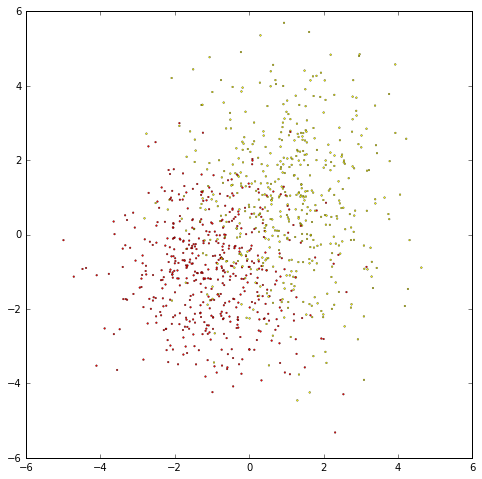

In [29]:
# Training data - two randomly-generated Gaussian-distributed clouds of points in 2d space
np.random.seed(0)
# Number of points
N = 1000
# Labels for each cluster
y = np.random.random_integers(0, 1, N)
# Mean of each cluster
means = np.array([[-1, 1], [-1, 1]])
# Covariance (in X and Y direction) of each cluster
covariances = np.random.random_sample((2, 2)) + 1
# Dimensions of each point
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]]).astype(theano.config.floatX)
# Convert to targets, as floatX
y = y.astype(theano.config.floatX)
# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(X[0, :], X[1, :], c=y, lw=.3, s=3, cmap=plt.cm.autumn)
plt.axis([-6, 6, -6, 6])
plt.show()

In [30]:
# First, set the size of each layer (and the number of layers)
# Input layer size is training data dimensionality (2)
# Output size is just 1-d: class label - 0 or 1
# Finally, let the hidden layers be twice the size of the input.
# If we wanted more layers, we could just add another layer size to this list.
layer_sizes = [X.shape[0], X.shape[0]*2, 1]
# Set initial parameter values
W_init = []
b_init = []
activations = []
for n_input, n_output in zip(layer_sizes[:-1], layer_sizes[1:]):
    # Getting the correct initialization matters a lot for non-toy problems.
    # However, here we can just use the following initialization with success:
    # Normally distribute initial weights
    W_init.append(np.random.randn(n_output, n_input))
    # Set initial biases to 1
    b_init.append(np.ones(n_output))
    # We'll use sigmoid activation for all layers
    # Note that this doesn't make a ton of sense when using squared distance
    # because the sigmoid function is bounded on [0, 1].
    activations.append(T.nnet.sigmoid)
    

In [31]:
# Create an instance of the MLP class
mlp = MLP(W_init, b_init, activations)

In [32]:
# Create Theano variables for the MLP input
mlp_input = T.matrix('mlp_input')
# ... and the desired output
mlp_target = T.vector('mlp_target')
# Learning rate and momentum hyperparameter values
# Again, for non-toy problems these values can make a big difference
# as to whether the network (quickly) converges on a good local minimum.
learning_rate = 0.01
momentum = 0.9
# Create a function for computing the cost of the network given an input
cost = mlp.squared_error(mlp_input, mlp_target)
# Create a theano function for training the network
train = theano.function([mlp_input, mlp_target], cost,
                        updates=gradient_updates_momentum(cost, mlp.params, learning_rate, momentum))
# Create a theano function for computing the MLP's output given some input
mlp_output = theano.function([mlp_input], mlp.output(mlp_input))

IndexError: ('The following error happened while compiling the node', Dot22(W, mlp_input), '\n', 'list index out of range')

In [33]:
# Keep track of the number of training iterations performed
iteration = 0
# We'll only train the network with 20 iterations.
# A more common technique is to use a hold-out validation set.
# When the validation error starts to increase, the network is overfitting,
# so we stop training the net.  This is called "early stopping", which we won't do here.
max_iteration = 20
while iteration < max_iteration:
    # Train the network using the entire training set.
    # With large datasets, it's much more common to use stochastic or mini-batch gradient descent
    # where only a subset (or a single point) of the training set is used at each iteration.
    # This can also help the network to avoid local minima.
    current_cost = train(X, y)
    # Get the current network output for all points in the training set
    current_output = mlp_output(X)
    # We can compute the accuracy by thresholding the output
    # and computing the proportion of points whose class match the ground truth class.
    accuracy = np.mean((current_output > .5) == y)
    # Plot network output after this iteration
    plt.figure(figsize=(8, 8))
    plt.scatter(X[0, :], X[1, :], c=current_output,
                lw=.3, s=3, cmap=plt.cm.amfhot, vmin=0, vmax=1)
    plt.axis([-6, 6, -6, 6])
    plt.title('Cost: {:.3f}, Accuracy: {:.3f}'.format(float(current_cost), accuracy))
    plt.show()
    iteration += 1

NameError: name 'train' is not defined